In [1]:
#plots.py
import os
import pandas
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import datetime
import math

def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

def plot_ts_scatter(df, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    plot_vars = list(df.keys())
    for var1 in plot_vars:
        for var2 in plot_vars:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(plot_vars).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_lines(df, title = False, linewidth = 1, figsize = (40,20), full_index = False, 
               h_line = False, max_y = False, legend = True, pp = None, show_inversion = False):
    fig, ax = plt.subplots(figsize = figsize)
    # If no secondary_y (axis), plot all variables at once
    df.plot.line(linewidth = linewidth, ax = ax, legend = legend)
    if h_line != False:
        ax.axhline(h_line, ls = "--", linewidth = 1.5, color = "k")
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    if max_y != False:
        ax.set_ylim(bottom = 0, top = max_y)
    if full_index:
        plt.xticks([i for i in range(len(df.index))], list(df.index))
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 

    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 
    if title != False:
        plt.title(title, fontsize = 72)

    if show_inversion:
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(df.index, 0, df.max().max(), where=df["2 Y (%)"] < df["1 M (%)"],
                    facecolor='red', alpha=0.2, transform = trans)
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    plt.savefig(filename[:50] + " line.png",
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_stacked_lines(df, plot_vars, linewidth = 1, figsize = (40,20), 
                       pp = None, total_var = False):
    fig, ax = plt.subplots(figsize = figsize)
#    mpl_colors = ["C" + str(i) for i in range(11)]
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax, c = "k",
              label = total_var, ls = "--")
    ax.legend(loc=2, ncol = 2)

In [2]:
data_codes  = {"1 M (%)": "DGS1MO",
               #"2 Month (%)": "DGS2MO",
               "3 M (%)": "DGS3MO",
               "6 M (%)": "DGS6MO",               
               "1 Y (%)": "DGS1",
               "2 Y (%)": "DGS2",
               "3 Y (%)": "DGS3",
               "5 Y (%)": "DGS5",
               "7 Y (%)": "DGS7",
               "10 Y (%)": "DGS10",
               "20 Y (%)": "DGS20",
               "30 Y (%)": "DGS30",}
 #             "Expected Inflation (%)":"T10YIE"}
               
# Select start and end dates
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "D").dropna()
data["30 Y - 1 M"] = data["30 Y (%)"].sub(data["1 M (%)"])
#data["Inflation (%)"] = data["Inflation (%)"].pct_change(12)*100

In [3]:
data.dropna()

,1 M (%),3 M (%),6 M (%),1 Y (%),2 Y (%),3 Y (%),5 Y (%),7 Y (%),10 Y (%),20 Y (%),30 Y (%),30 Y - 1 M
DATE,,,,,,,,,,,,
2006-01-03,4.05,4.16,4.40,4.38,4.34,4.30,4.30,4.32,4.37,4.62,4.52,0.47
2006-01-04,4.03,4.19,4.37,4.35,4.31,4.28,4.28,4.31,4.36,4.60,4.55,0.52
2006-01-05,4.05,4.20,4.37,4.36,4.32,4.29,4.29,4.31,4.36,4.61,4.51,0.46
2006-01-06,4.06,4.22,4.39,4.38,4.36,4.32,4.32,4.33,4.38,4.63,4.53,0.47
2006-01-09,4.09,4.23,4.40,4.39,4.36,4.32,4.32,4.34,4.38,4.63,4.53,0.44
2006-01-10,4.15,4.29,4.42,4.42,4.41,4.36,4.36,4.38,4.43,4.68,4.62,0.47
2006-01-11,4.16,4.30,4.45,4.44,4.44,4.39,4.39,4.41,4.46,4.70,4.61,0.45
2006-01-12,4.16,4.32,4.43,4.42,4.39,4.35,4.35,4.37,4.42,4.66,4.56,0.40
2006-01-13,4.13,4.33,4.43,4.40,4.34,4.29,4.28,4.30,4.36,4.59,4.49,0.36


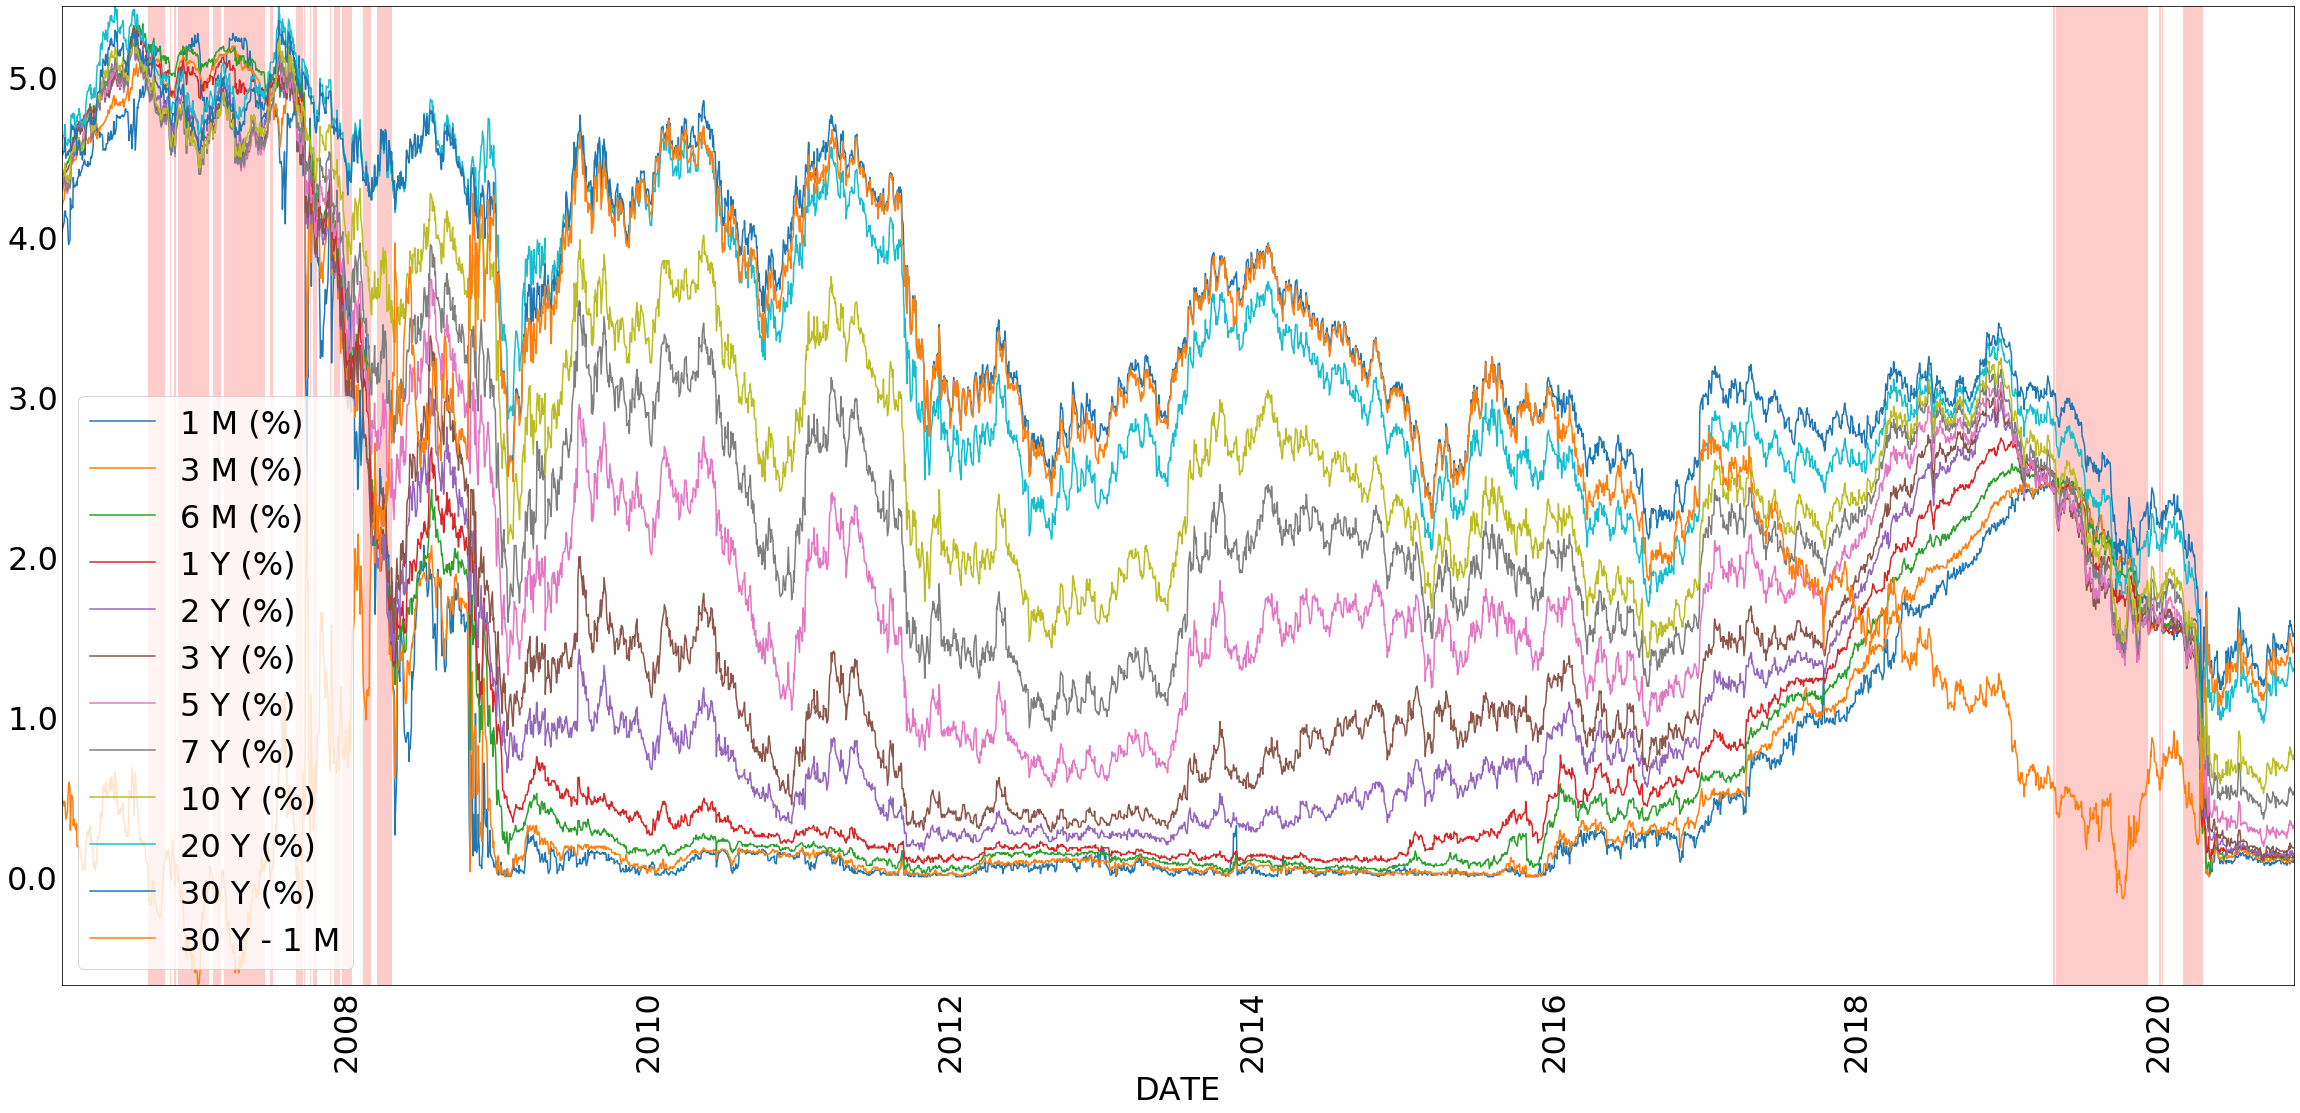

In [4]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = 0

plot_lines(df = data, linewidth = 1.5, figsize = (40, 20), pp = None, show_inversion = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


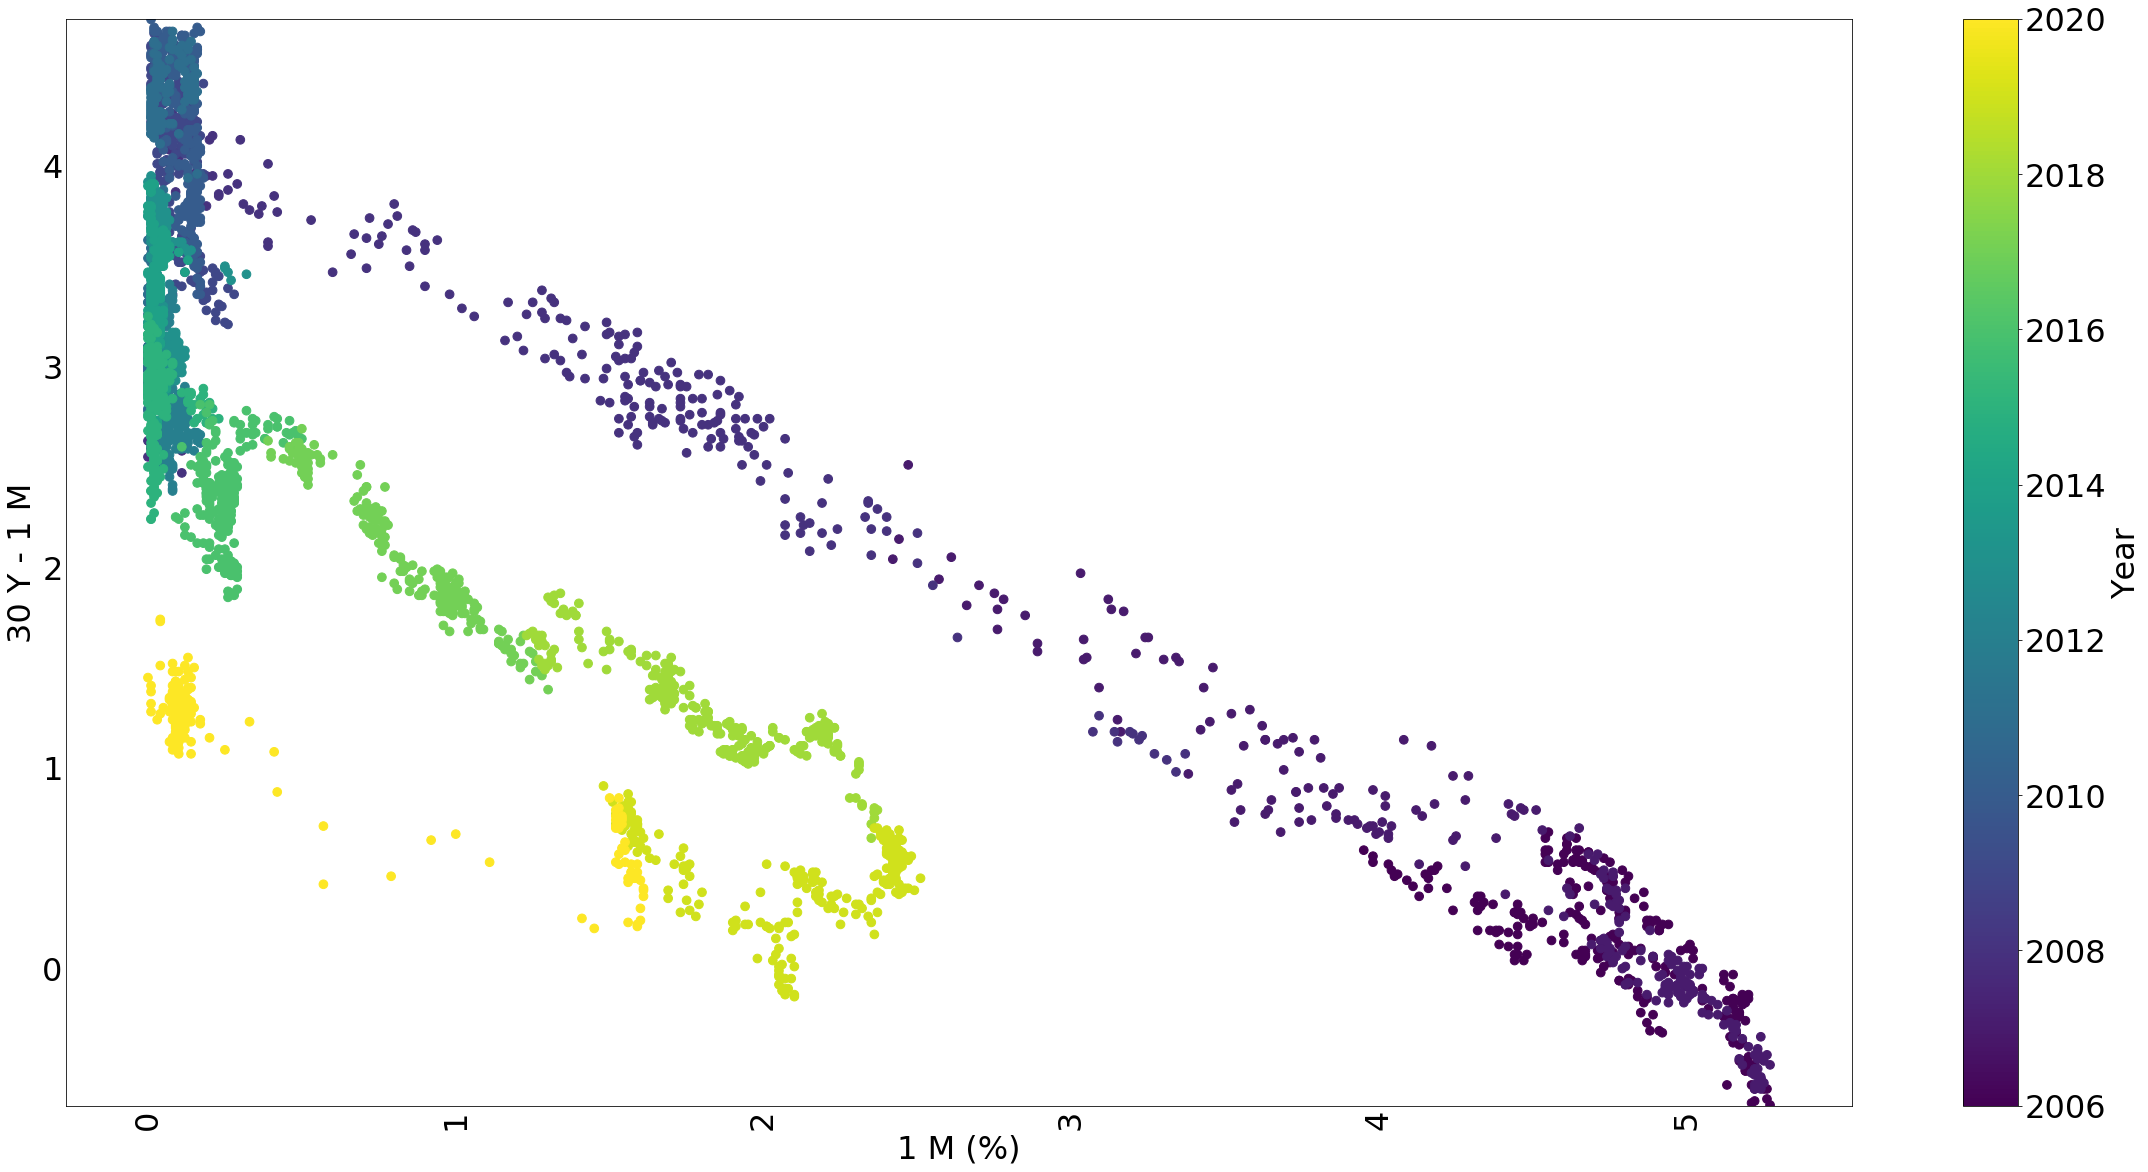

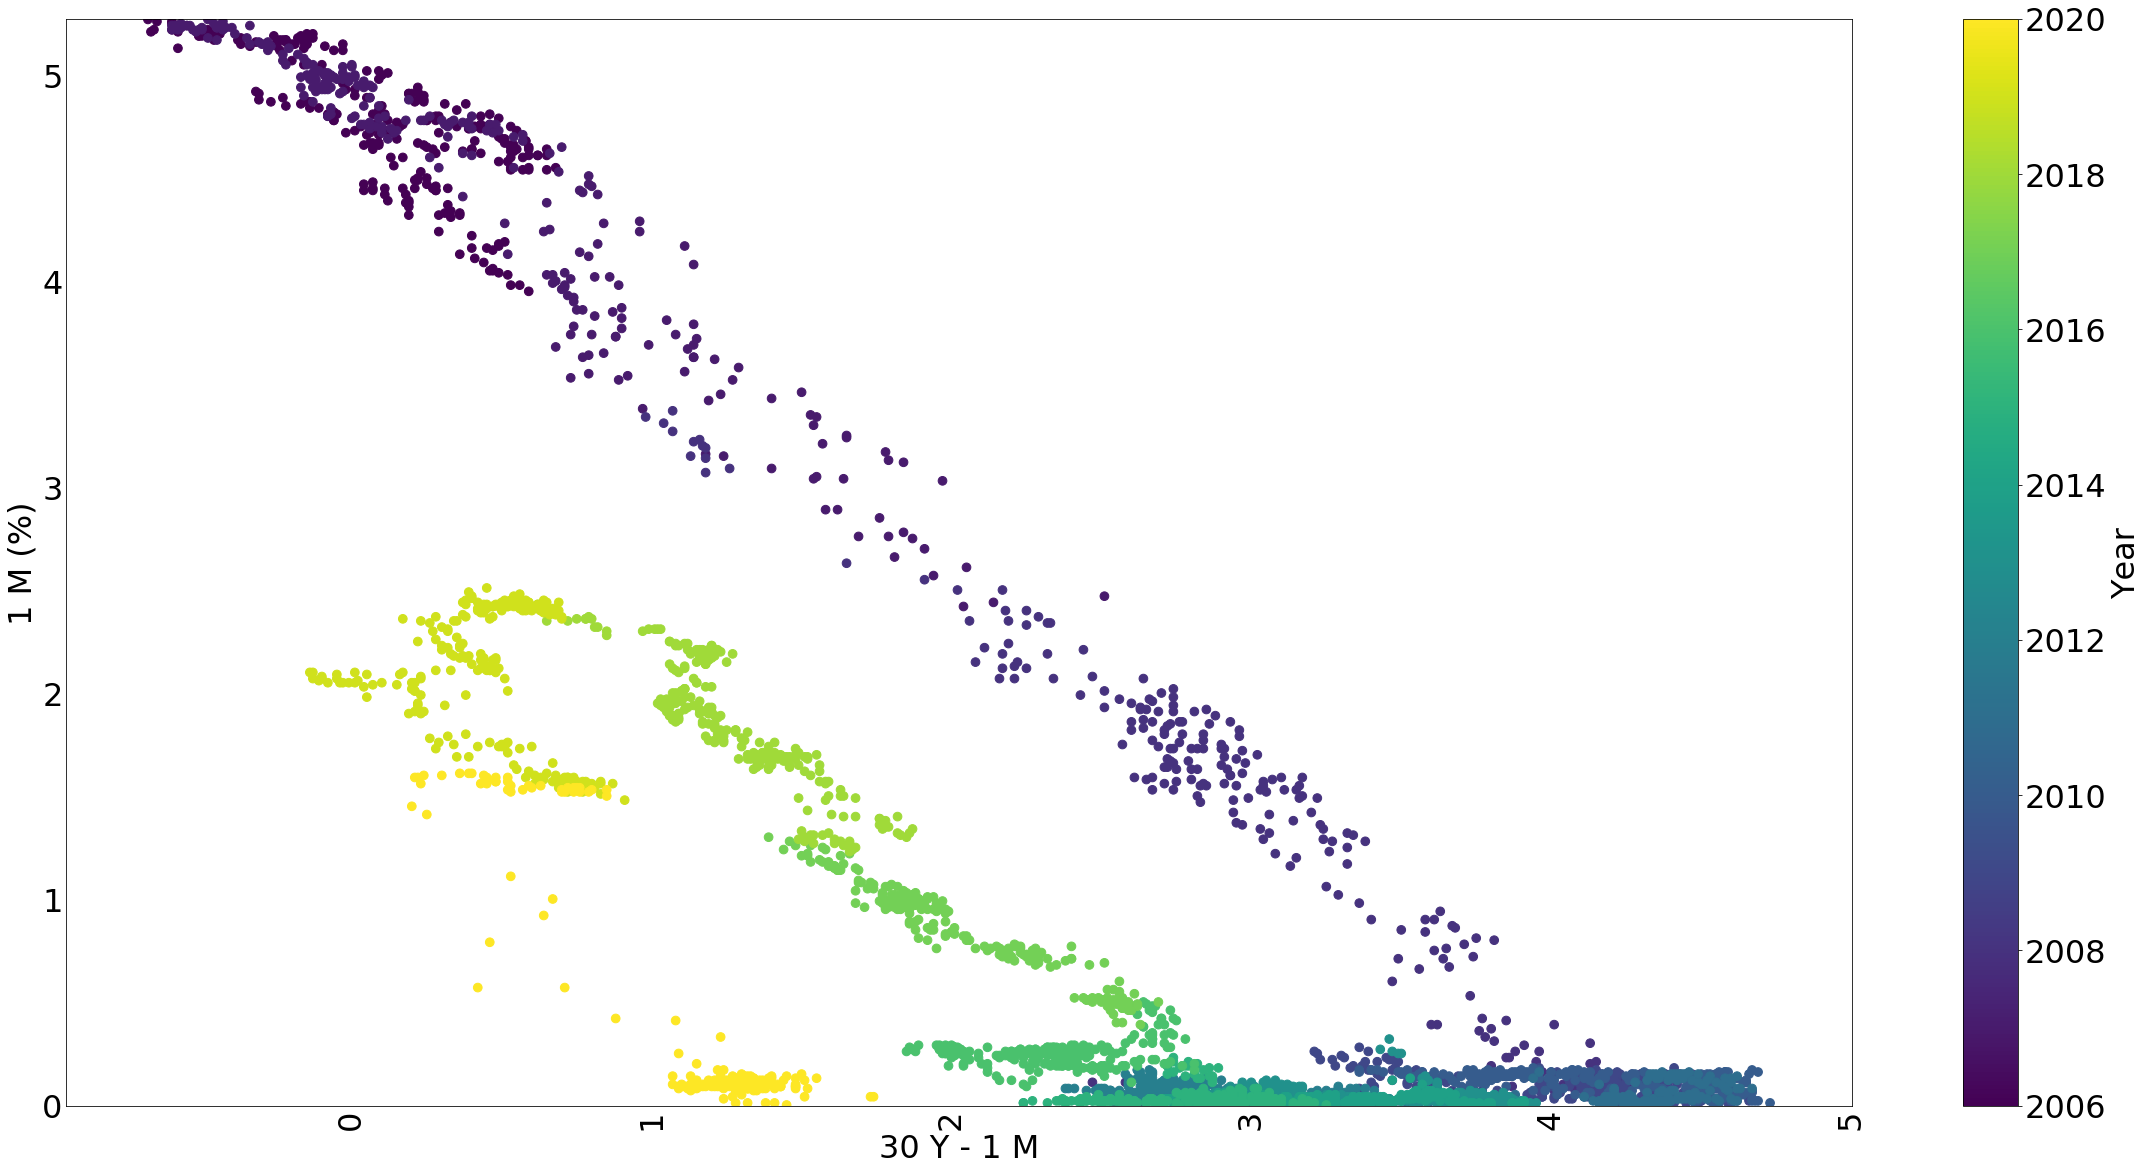

In [5]:
plot_ts_scatter(data[["1 M (%)", "30 Y - 1 M"]], s = 75, figsize = (40, 20))

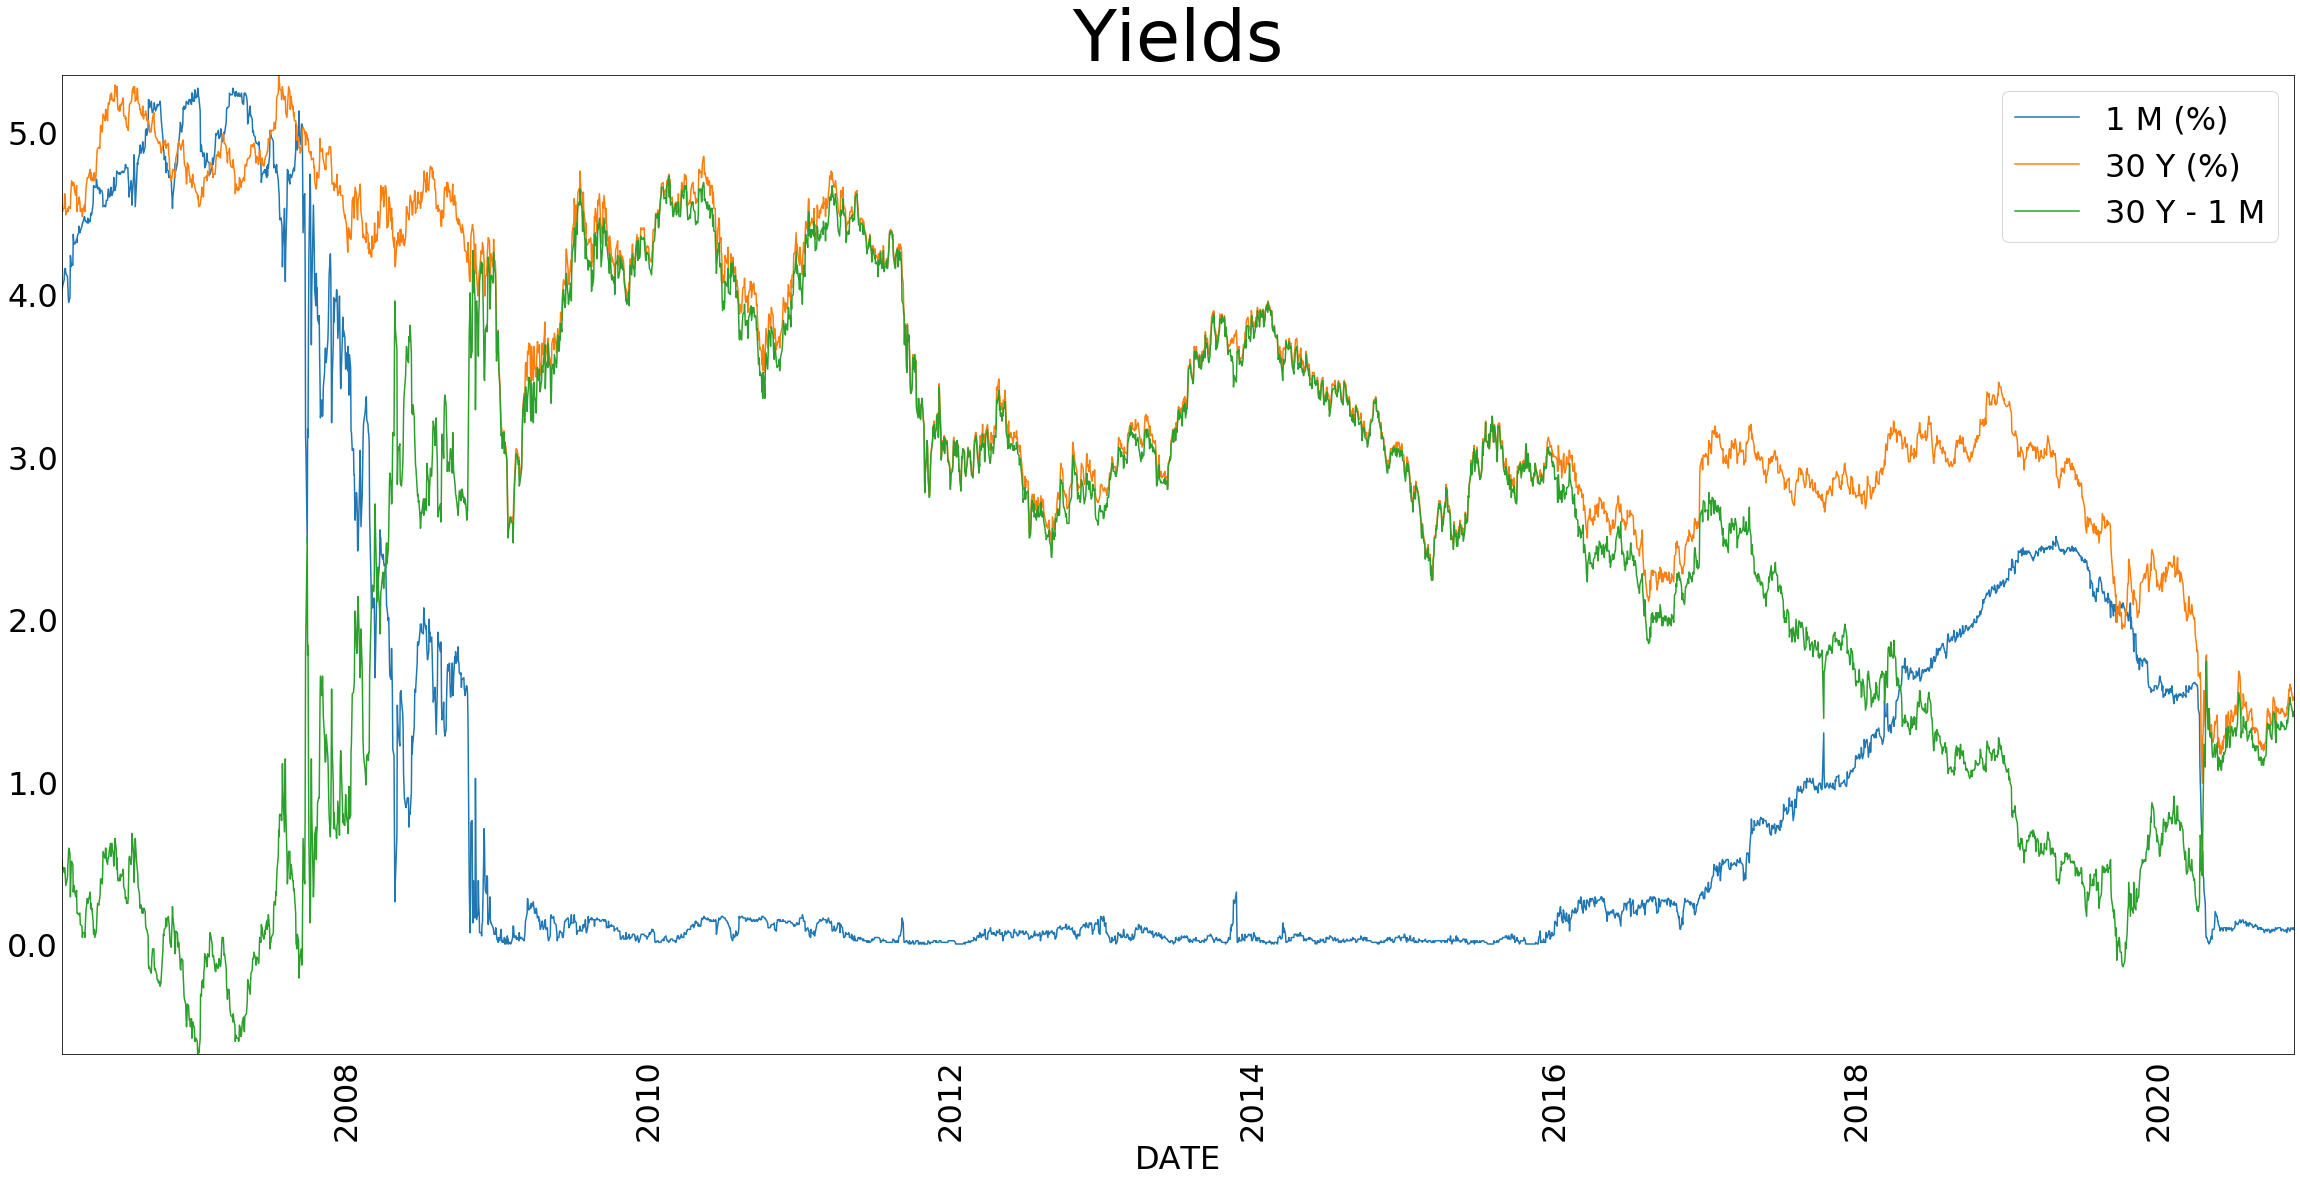

In [6]:
plot_lines(df = data[["1 M (%)", "30 Y (%)", "30 Y - 1 M"]], title = "Yields", linewidth = 1.5, figsize = (40, 20), pp = None)

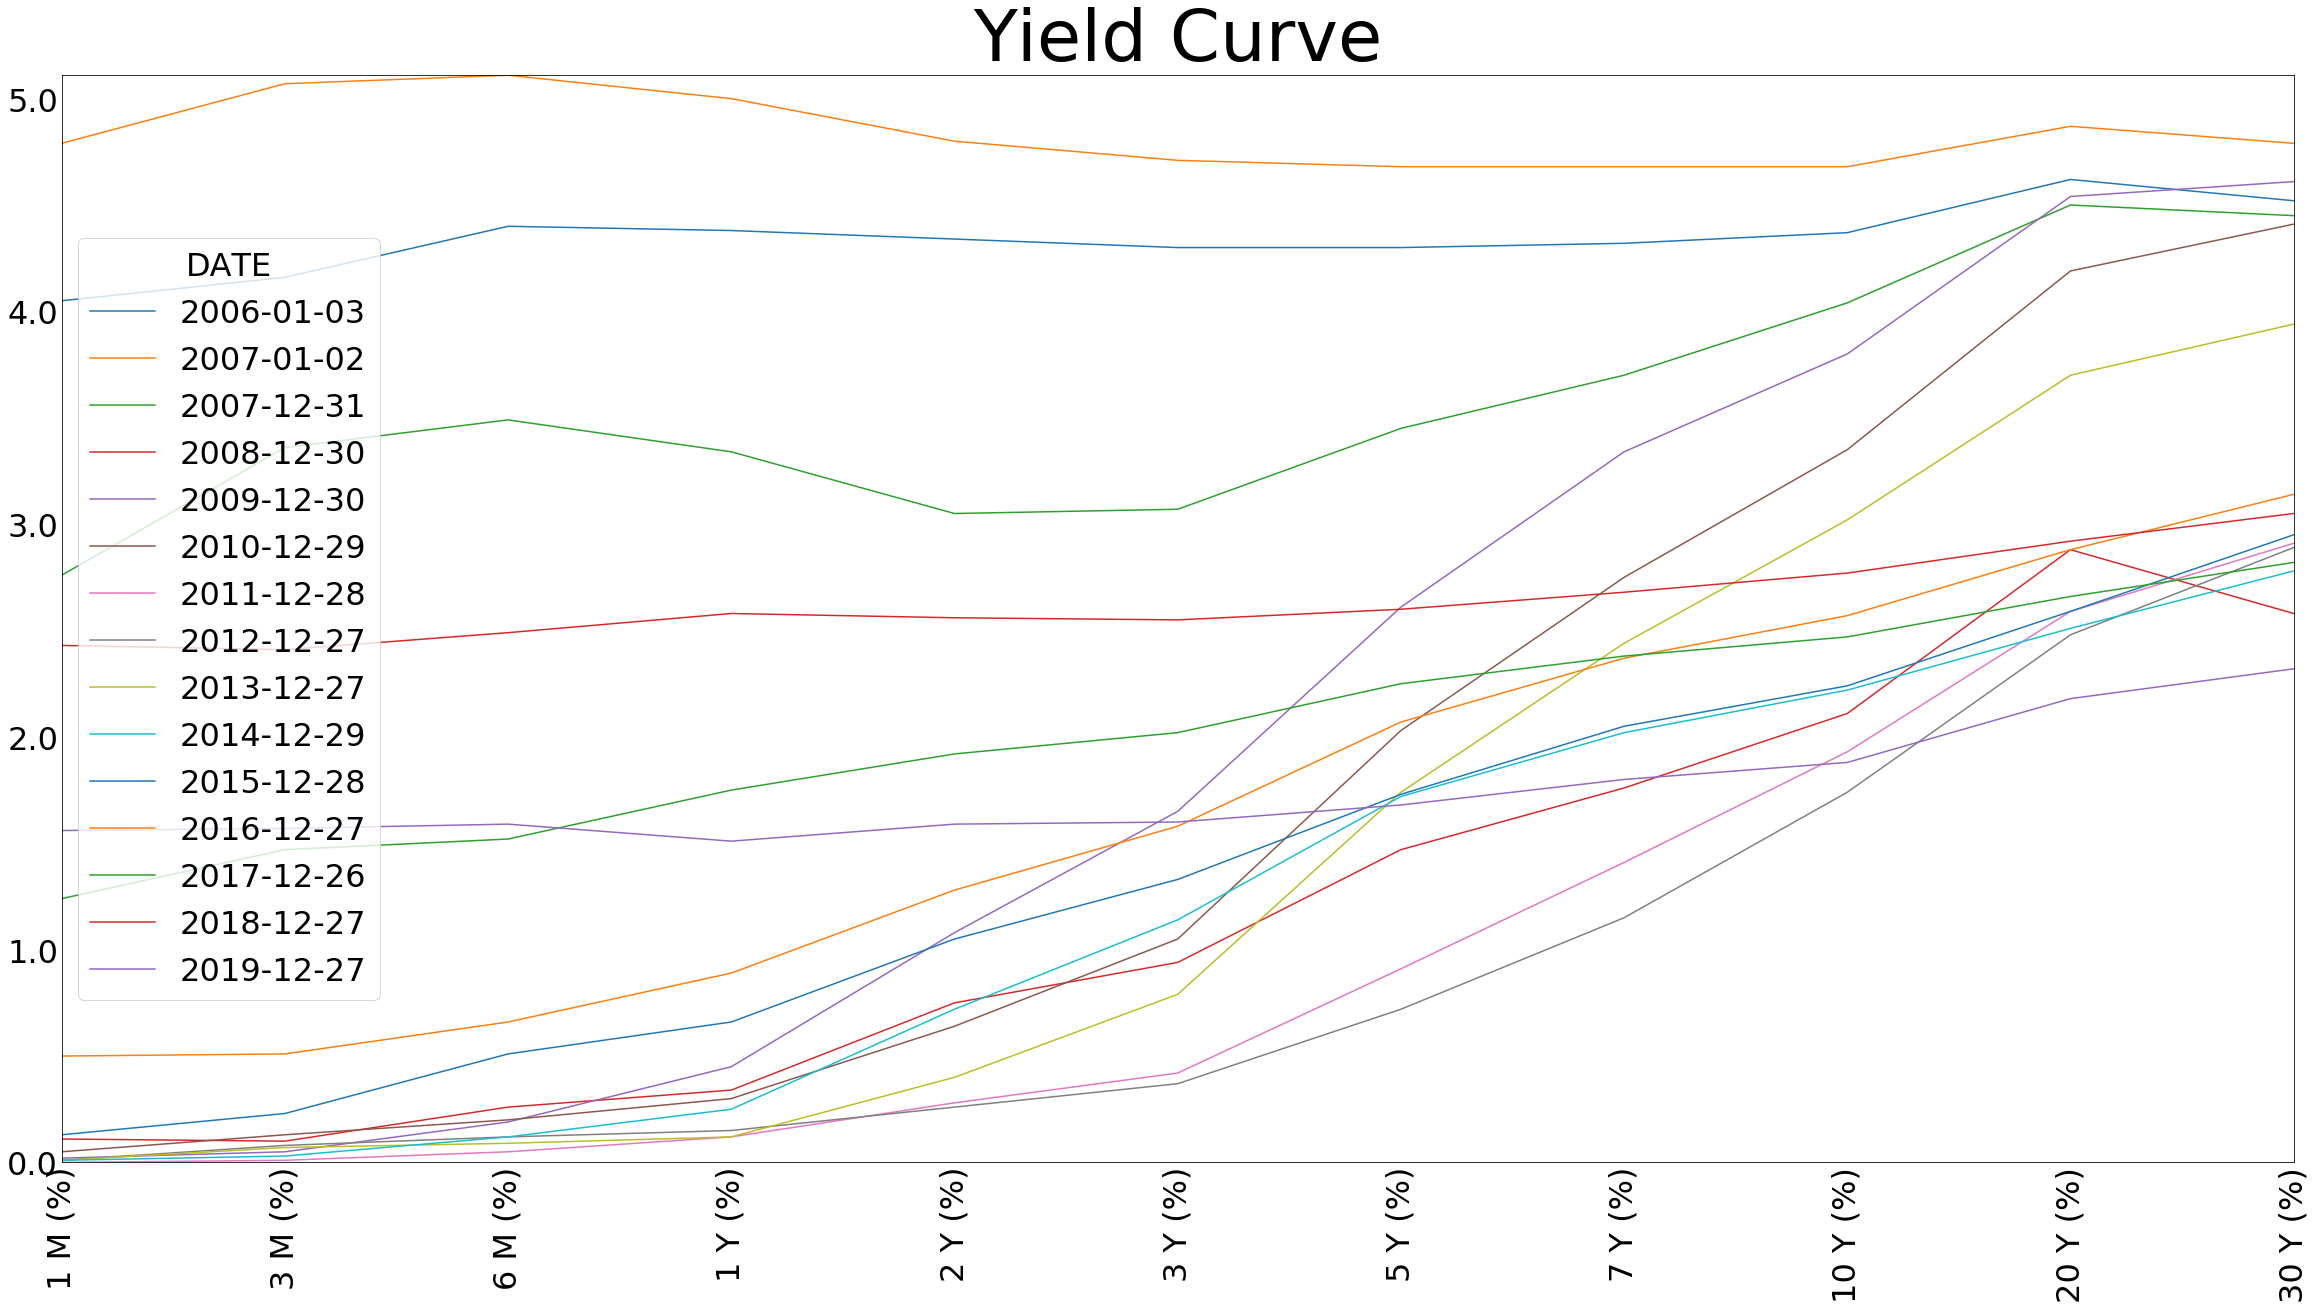

In [7]:
T_data = data.T
T_data.rename(columns={name : str(name)[:10] for name in T_data.keys()}, inplace = True)
keys = list(T_data.keys())
# Plot all maturities, remove "30 Y - 1 M" dataframe
T_data_trunc = T_data[keys[::250]].drop("30 Y - 1 M")
max_y = T_data.max().max()
#for key, val in T_data_trunc.items():
plot_lines(df = T_data_trunc, title = "Yield Curve", linewidth = 1.5, 
           figsize = (40, 20), full_index = True, legend = True, pp = None)

In [10]:
from matplotlib.animation import FuncAnimation
import math         
def plot_curves(date, *kwargs):
    #ax.clear()
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])
 
    # the FuncAnimation cycles from 0 to i frames,
    plot_df = df[date]
    alpha = 1 if date in write_dates else .1
    color = "C" + str(math.ceil(int(date[5:7])/3)) if date != write_dates[0] else "k"

    # If no secondary_y (axis), plot all variables at once

    plot_df.plot.line(linewidth = linewidth, ax = ax, alpha = alpha, color = color)
    if date in write_dates: 
        plt.text(len(plot_df.keys()) - 1, plot_df["30 Y (%)"], date[5:], color = color)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(str(date)[:10] + "\n" + "Yield Curve (U.S. Treasuries)", fontsize = 30)
    print(date)
    
def init(*kwargs):
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    plt.xticks([i for i in range(len(data.index))], list(data.index))
    ax.tick_params(axis='x', rotation=90)
    # transform y-axis values from sci notation to integers
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])

dates = list(T_data.keys())[-166:]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2020CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24
2020-04-27
2020-04-28
2020-04-29
2020-04-30
2020-05-01
2020-05-04
2020-05-05
2020-05-06
2020-05-07
2020-05-08
2020-05-11
2020-05-12
2020-05-13
2020-05-14
2020-05-15
2020-05-18
2020-05-19
2020-05-20
2020-05-21
2020-05-22
2020-05-26
2020-05-27
2020-05-28
2020-05-29
2020-06-01
2020-06-02
2020-06-03
2020-06-04
2020-06-05
2020-06-08
2020-06-09
2020-06-10
2020-06-11
2020-06-12
2020-06-15
2020-06-16
2020-06-17
2020-06-18
2020-06-19
2020-06-22
2020-06-23
2020-06-24
2020-06-25
2020-06-26
2020-06-29
2020-06-30

In [11]:
dates = list(T_data.keys())[620:770]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2008CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

2008-06-23
2008-06-24
2008-06-25
2008-06-26
2008-06-27
2008-06-30
2008-07-01
2008-07-02
2008-07-03
2008-07-07
2008-07-08
2008-07-09
2008-07-10
2008-07-11
2008-07-14
2008-07-15
2008-07-16
2008-07-17
2008-07-18
2008-07-21
2008-07-22
2008-07-23
2008-07-24
2008-07-25
2008-07-28
2008-07-29
2008-07-30
2008-07-31
2008-08-01
2008-08-04
2008-08-05
2008-08-06
2008-08-07
2008-08-08
2008-08-11
2008-08-12
2008-08-13
2008-08-14
2008-08-15
2008-08-18
2008-08-19
2008-08-20
2008-08-21
2008-08-22
2008-08-25
2008-08-26
2008-08-27
2008-08-28
2008-08-29
2008-09-02
2008-09-03
2008-09-04
2008-09-05
2008-09-08
2008-09-09
2008-09-10
2008-09-11
2008-09-12
2008-09-15
2008-09-16
2008-09-17
2008-09-18
2008-09-19
2008-09-22
2008-09-23
2008-09-24
2008-09-25
2008-09-26
2008-09-29
2008-09-30
2008-10-01
2008-10-02
2008-10-03
2008-10-06
2008-10-07
2008-10-08
2008-10-09
2008-10-10
2008-10-14
2008-10-15
2008-10-16
2008-10-17
2008-10-20
2008-10-21
2008-10-22
2008-10-23
2008-10-24
2008-10-27
2008-10-28
2008-10-29
2008-10-30